# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


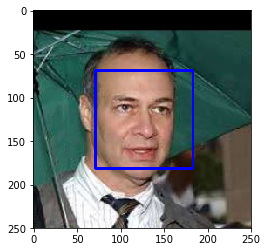

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[13232])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)
#print(faces)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
#print(dog_files_short)
human=[]
dog=[]
for i in range(len(human_files_short)):
    dog.append((face_detector(dog_files_short[i])))
    human.append((face_detector(human_files_short[i])))
print(" The percentage of human faces detected in human dataset is %d%% "%np.count_nonzero(human))
print(" The percentage of human faces detected in dog dataset is %d%% "%np.count_nonzero(dog))

 The percentage of human faces detected in human dataset is 98% 
 The percentage of human faces detected in dog dataset is 11% 


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

__ANSWER:__A clear view of face is not an acceptable premise in real-life scenarios. This can be prevented in many ways. If utilizing haar-cascades, we can include other xml cascade files that also account for profile or skewed views, and even create our own, OpenCV has a train-cascade facility for that sole purpose.However,it takes more time and is not nearly so precise as constructing a deep learning network.Locally in my own laptop, I built a deep neural network with 2 groups of CONV_RELU_POOL layers along with a GAP layer to gather the best features and flatten the data, then two FC layers with a softmax activation for the final classification. The code runs over a tiny 200 images dataset (100 humans and 100 dogs) and over only 200 epochs. This took roughly 45 minutes to train and yielded and accuracy of 92.5%.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human1=[]
dog1=[]
for i in range(len(human_files_short)):
    dog1.append((dog_detector(dog_files_short[i])))
    human1.append((dog_detector(human_files_short[i])))
print(" The percentage of dogs detected in human dataset is %d%% "%np.count_nonzero(human1))
print(" The percentage of dogs detected in dog dataset is %d%% "%np.count_nonzero(dog1))

 The percentage of dogs detected in human dataset is 2% 
 The percentage of dogs detected in dog dataset is 100% 


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 168.10it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I tried to use a multi-layer CNN with increasing number of filters to progressively detect more complex shapes. I also used dropout to prevent overfitting, maxpooling to reduce the inputs as we progress through the layers and also used BatchNormalization layer, and a new activation function called PReLU in order to improve accuracy!

In [64]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU

model = Sequential()
act = PReLU(init='zero', weights=None)
### TODO: Define your architecture.
#this is the convolutional layer with input of the shape of training data
model.add(Conv2D(input_shape=(224,224,3),filters=16,kernel_size=8,padding='same',activation='relu'))
#added maxpoolLayer to reduce the height and width of convo layer
model.add(MaxPooling2D(pool_size=4))
#added dropout of 0.2 to avoid overfitting in the first layer
model.add(Dropout(0.2))
#increasing the filter size so that the depth of the new layer increases 
model.add(Conv2D(filters=64,kernel_size=2,padding='same'))
model.add(act)
model.add(MaxPooling2D(pool_size=4))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(190, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 16)      3088      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 56, 56, 64)        200704    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(alpha_initializer="zero", weights=None)`
  


### Compile the Model

In [65]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [66]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 23s - loss: 4.8898 - acc: 0.0096 - val_loss: 4.8769 - val_acc: 0.0108
Epoch 2/5
6680/6680 [==============================] - 22s - loss: 4.8509 - acc: 0.0130 - val_loss: 4.8607 - val_acc: 0.0108
Epoch 3/5
6680/6680 [==============================] - 22s - loss: 4.8070 - acc: 0.0183 - val_loss: 4.7675 - val_acc: 0.0192
Epoch 4/5
6680/6680 [==============================] - 22s - loss: 4.7421 - acc: 0.0199 - val_loss: 4.7226 - val_acc: 0.0251
Epoch 5/5
6680/6680 [==============================] - 22s - loss: 4.7021 - acc: 0.0213 - val_loss: 4.7626 - val_acc: 0.0168


### Load the Model with the Best Validation Loss

In [67]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [68]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.5120%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [20]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.1896 - acc: 0.1244 - val_loss: 10.8983 - val_acc: 0.1868
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.0918 - acc: 0.2841 - val_loss: 10.1597 - val_acc: 0.2862
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.6300 - acc: 0.3425 - val_loss: 9.7843 - val_acc: 0.3018
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.3217 - acc: 0.3789 - val_loss: 9.7678 - val_acc: 0.3198
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.2263 - acc: 0.3969 - val_loss: 9.5932 - val_acc: 0.3425
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.1363 - acc: 0.4111 - val_loss: 9.4962 - val_acc: 0.3341
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.9249 - acc: 0.4268 - val_loss: 9.4251 - val_acc: 0.3533
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.8514 

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.6699%


### Predict Dog Breed with the Model

In [26]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [27]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

print(train_VGG19.shape)

(6680, 7, 7, 512)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ At first, I started using Resnet50 I got an accuracy of 81% which makes the problem(achieving greater than 60%) easier to solve.To make it even more challenging I used VGG19 which is less deeper than Resnet50 and gained an accuracy of 56% which upon tuning gave me a 69% I choose VGG19 because there are more consecutively stacked 3x3 convolutional layers in the high layers than the lower layers.When the input is large, this induces more memory consumption and slower runtime.The VGG19 architecture decodes to reduce the input size to loose these constraints first then start to use 3x3 layers to keep the representation power for the upcoming layers, which tends to speed up the process.


In [28]:
my_model = Sequential()

my_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
#my_model.add(Dropout(0.65))
my_model.add(Dropout(0.1))
my_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [29]:
### TODO: Compile the model.
my_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [30]:
### TODO: Train the model.

# from keras.preprocessing.image import ImageDataGenerator

# #create and configure augmented image generator
# datagen_train = ImageDataGenerator(
#    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
#    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
#    horizontal_flip=True) # randomly flip images horizontally

# # create and configure augmented image generator
# datagen_valid = ImageDataGenerator(
#    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
#    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
#    horizontal_flip=True) # randomly flip images horizontally

# # fit augmented image generator on data
# datagen_train.fit(train_VGG19)
# datagen_valid.fit(valid_VGG19)

# batch_size=100
# epochs=20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

my_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=1000, batch_size=100, callbacks=[checkpointer], verbose=1)

# my_model.fit_generator(datagen_train.flow(train_VGG19, train_targets, batch_size=batch_size),
#                    steps_per_epoch=train_VGG.shape[0] // batch_size,
#                    epochs=epochs, verbose=2, callbacks=[checkpointer],
#                    validation_data=datagen_valid.flow(valid_VGG19, valid_targets, batch_size=batch_size),
#                    validation_steps=valid_VGG19.shape[0] // batch_size)

Train on 6680 samples, validate on 835 samples
Epoch 1/1000
6680/6680 [==============================] - 1s - loss: 12.0765 - acc: 0.0907 - val_loss: 9.7348 - val_acc: 0.1964
Epoch 2/1000
6680/6680 [==============================] - 0s - loss: 9.0752 - acc: 0.2434 - val_loss: 8.0730 - val_acc: 0.3066
Epoch 3/1000
6680/6680 [==============================] - 0s - loss: 7.7988 - acc: 0.3528 - val_loss: 7.3963 - val_acc: 0.3784
Epoch 4/1000
6680/6680 [==============================] - 0s - loss: 7.0061 - acc: 0.4246 - val_loss: 6.9416 - val_acc: 0.4132
Epoch 5/1000
6680/6680 [==============================] - 0s - loss: 6.4533 - acc: 0.4829 - val_loss: 6.6501 - val_acc: 0.4503
Epoch 6/1000
6680/6680 [==============================] - 0s - loss: 6.2422 - acc: 0.5138 - val_loss: 6.5047 - val_acc: 0.4790
Epoch 7/1000
6680/6680 [==============================] - 0s - loss: 6.0904 - acc: 0.5416 - val_loss: 6.5165 - val_acc: 0.4719
Epoch 8/1000
6680/6680 [==============================] - 0s - 

6680/6680 [==============================] - 0s - loss: 5.4885 - acc: 0.6516 - val_loss: 6.2549 - val_acc: 0.5269
Epoch 31/1000
6680/6680 [==============================] - 0s - loss: 5.4819 - acc: 0.6525 - val_loss: 6.2501 - val_acc: 0.5246
Epoch 32/1000
6680/6680 [==============================] - 0s - loss: 5.4674 - acc: 0.6503 - val_loss: 6.2680 - val_acc: 0.5126
Epoch 33/1000
6680/6680 [==============================] - 0s - loss: 5.4325 - acc: 0.6540 - val_loss: 6.2752 - val_acc: 0.5269
Epoch 34/1000
6680/6680 [==============================] - 0s - loss: 5.4324 - acc: 0.6527 - val_loss: 6.2642 - val_acc: 0.5114
Epoch 35/1000
6680/6680 [==============================] - 0s - loss: 5.4181 - acc: 0.6539 - val_loss: 6.2593 - val_acc: 0.5293
Epoch 36/1000
6680/6680 [==============================] - 0s - loss: 5.4127 - acc: 0.6539 - val_loss: 6.2133 - val_acc: 0.5257
Epoch 37/1000
6680/6680 [==============================] - 0s - loss: 5.3308 - acc: 0.6561 - val_loss: 6.1286 - val_ac

6680/6680 [==============================] - 0s - loss: 4.6330 - acc: 0.7070 - val_loss: 5.5840 - val_acc: 0.5641
Epoch 61/1000
6680/6680 [==============================] - 0s - loss: 4.6217 - acc: 0.7100 - val_loss: 5.5860 - val_acc: 0.5629
Epoch 62/1000
6680/6680 [==============================] - 0s - loss: 4.6316 - acc: 0.7072 - val_loss: 5.5354 - val_acc: 0.5677
Epoch 63/1000
6680/6680 [==============================] - 0s - loss: 4.6279 - acc: 0.7082 - val_loss: 5.6300 - val_acc: 0.5689
Epoch 64/1000
6680/6680 [==============================] - 0s - loss: 4.5822 - acc: 0.7072 - val_loss: 5.5030 - val_acc: 0.5713
Epoch 65/1000
6680/6680 [==============================] - 0s - loss: 4.4785 - acc: 0.7126 - val_loss: 5.3866 - val_acc: 0.5880
Epoch 66/1000
6680/6680 [==============================] - 0s - loss: 4.4527 - acc: 0.7184 - val_loss: 5.4166 - val_acc: 0.5844
Epoch 67/1000
6680/6680 [==============================] - 0s - loss: 4.4437 - acc: 0.7189 - val_loss: 5.4395 - val_ac

6680/6680 [==============================] - 0s - loss: 3.9054 - acc: 0.7449 - val_loss: 5.1089 - val_acc: 0.5928
Epoch 92/1000
6680/6680 [==============================] - 0s - loss: 3.7958 - acc: 0.7501 - val_loss: 4.8724 - val_acc: 0.6084
Epoch 93/1000
6680/6680 [==============================] - 0s - loss: 3.7310 - acc: 0.7581 - val_loss: 4.8932 - val_acc: 0.6084
Epoch 94/1000
6680/6680 [==============================] - 0s - loss: 3.7125 - acc: 0.7615 - val_loss: 4.9281 - val_acc: 0.5928
Epoch 95/1000
6680/6680 [==============================] - 0s - loss: 3.7061 - acc: 0.7632 - val_loss: 4.8705 - val_acc: 0.6096
Epoch 96/1000
6680/6680 [==============================] - 0s - loss: 3.6983 - acc: 0.7647 - val_loss: 4.8677 - val_acc: 0.6120
Epoch 97/1000
6680/6680 [==============================] - 0s - loss: 3.6918 - acc: 0.7665 - val_loss: 4.9004 - val_acc: 0.6156
Epoch 98/1000
6680/6680 [==============================] - 0s - loss: 3.6898 - acc: 0.7665 - val_loss: 4.8607 - val_ac

6680/6680 [==============================] - 0s - loss: 3.5557 - acc: 0.7760 - val_loss: 4.8481 - val_acc: 0.6120
Epoch 122/1000
6680/6680 [==============================] - 0s - loss: 3.5556 - acc: 0.7775 - val_loss: 4.7261 - val_acc: 0.6240
Epoch 123/1000
6680/6680 [==============================] - 0s - loss: 3.5546 - acc: 0.7768 - val_loss: 4.7558 - val_acc: 0.6180
Epoch 124/1000
6680/6680 [==============================] - 0s - loss: 3.5536 - acc: 0.7775 - val_loss: 4.8263 - val_acc: 0.6168
Epoch 125/1000
6680/6680 [==============================] - 0s - loss: 3.5517 - acc: 0.7772 - val_loss: 4.8008 - val_acc: 0.6228
Epoch 126/1000
6680/6680 [==============================] - 0s - loss: 3.5526 - acc: 0.7768 - val_loss: 4.7802 - val_acc: 0.6204
Epoch 127/1000
6680/6680 [==============================] - 0s - loss: 3.5514 - acc: 0.7777 - val_loss: 4.7961 - val_acc: 0.6204
Epoch 128/1000
6680/6680 [==============================] - 0s - loss: 3.5530 - acc: 0.7772 - val_loss: 4.8184 -

6680/6680 [==============================] - 0s - loss: 3.4244 - acc: 0.7858 - val_loss: 4.7053 - val_acc: 0.6311
Epoch 154/1000
6680/6680 [==============================] - 0s - loss: 3.4253 - acc: 0.7861 - val_loss: 4.7047 - val_acc: 0.6335
Epoch 155/1000
6680/6680 [==============================] - 0s - loss: 3.4263 - acc: 0.7847 - val_loss: 4.7171 - val_acc: 0.6263
Epoch 156/1000
6680/6680 [==============================] - 0s - loss: 3.4234 - acc: 0.7858 - val_loss: 4.7195 - val_acc: 0.6156
Epoch 157/1000
6680/6680 [==============================] - 0s - loss: 3.4233 - acc: 0.7867 - val_loss: 4.7108 - val_acc: 0.6323
Epoch 158/1000
6680/6680 [==============================] - 0s - loss: 3.4241 - acc: 0.7861 - val_loss: 4.7988 - val_acc: 0.6251
Epoch 159/1000
6680/6680 [==============================] - 0s - loss: 3.4263 - acc: 0.7859 - val_loss: 4.7847 - val_acc: 0.6180
Epoch 160/1000
6680/6680 [==============================] - 0s - loss: 3.4268 - acc: 0.7855 - val_loss: 4.7543 -

6680/6680 [==============================] - 0s - loss: 3.1642 - acc: 0.7981 - val_loss: 4.6015 - val_acc: 0.6323
Epoch 187/1000
6680/6680 [==============================] - 0s - loss: 3.1568 - acc: 0.8000 - val_loss: 4.7207 - val_acc: 0.6240
Epoch 188/1000
6680/6680 [==============================] - 0s - loss: 3.1555 - acc: 0.8006 - val_loss: 4.6497 - val_acc: 0.6204
Epoch 189/1000
6680/6680 [==============================] - 0s - loss: 3.1534 - acc: 0.8006 - val_loss: 4.5860 - val_acc: 0.6311
Epoch 190/1000
6680/6680 [==============================] - 0s - loss: 3.1482 - acc: 0.8010 - val_loss: 4.5941 - val_acc: 0.6371
Epoch 191/1000
6680/6680 [==============================] - 0s - loss: 3.1449 - acc: 0.8021 - val_loss: 4.5673 - val_acc: 0.6275
Epoch 192/1000
6680/6680 [==============================] - 0s - loss: 3.1430 - acc: 0.8031 - val_loss: 4.5941 - val_acc: 0.6311
Epoch 193/1000
6680/6680 [==============================] - 0s - loss: 3.1429 - acc: 0.8012 - val_loss: 4.6209 -

6680/6680 [==============================] - 0s - loss: 3.0049 - acc: 0.8109 - val_loss: 4.5228 - val_acc: 0.6335
Epoch 217/1000
6680/6680 [==============================] - 0s - loss: 3.0031 - acc: 0.8117 - val_loss: 4.4878 - val_acc: 0.6359
Epoch 218/1000
6680/6680 [==============================] - 0s - loss: 2.9976 - acc: 0.8133 - val_loss: 4.4940 - val_acc: 0.6479
Epoch 219/1000
6680/6680 [==============================] - 0s - loss: 3.0032 - acc: 0.8127 - val_loss: 4.4934 - val_acc: 0.6407
Epoch 220/1000
6680/6680 [==============================] - 0s - loss: 3.0039 - acc: 0.8117 - val_loss: 4.5391 - val_acc: 0.6383
Epoch 221/1000
6680/6680 [==============================] - 0s - loss: 3.0031 - acc: 0.8117 - val_loss: 4.4677 - val_acc: 0.6347
Epoch 222/1000
6680/6680 [==============================] - 0s - loss: 2.9992 - acc: 0.8127 - val_loss: 4.5074 - val_acc: 0.6431
Epoch 223/1000
6680/6680 [==============================] - 0s - loss: 3.0037 - acc: 0.8120 - val_loss: 4.5198 -

6680/6680 [==============================] - 0s - loss: 2.7293 - acc: 0.8287 - val_loss: 4.3299 - val_acc: 0.6479
Epoch 249/1000
6680/6680 [==============================] - 0s - loss: 2.7334 - acc: 0.8274 - val_loss: 4.3665 - val_acc: 0.6467
Epoch 250/1000
6680/6680 [==============================] - 0s - loss: 2.7257 - acc: 0.8287 - val_loss: 4.4519 - val_acc: 0.6467
Epoch 251/1000
6680/6680 [==============================] - 0s - loss: 2.7285 - acc: 0.8286 - val_loss: 4.3654 - val_acc: 0.6467
Epoch 252/1000
6680/6680 [==============================] - 0s - loss: 2.7232 - acc: 0.8287 - val_loss: 4.3475 - val_acc: 0.6611
Epoch 253/1000
6680/6680 [==============================] - 0s - loss: 2.7020 - acc: 0.8257 - val_loss: 4.3677 - val_acc: 0.6503
Epoch 254/1000
6680/6680 [==============================] - 0s - loss: 2.6749 - acc: 0.8280 - val_loss: 4.3642 - val_acc: 0.6395
Epoch 255/1000
6680/6680 [==============================] - 0s - loss: 2.6572 - acc: 0.8320 - val_loss: 4.3772 -

6680/6680 [==============================] - 0s - loss: 2.4114 - acc: 0.8448 - val_loss: 4.2130 - val_acc: 0.6443
Epoch 280/1000
6680/6680 [==============================] - 0s - loss: 2.3940 - acc: 0.8464 - val_loss: 4.1444 - val_acc: 0.6479
Epoch 281/1000
6680/6680 [==============================] - 0s - loss: 2.3876 - acc: 0.8460 - val_loss: 4.1579 - val_acc: 0.6467
Epoch 282/1000
6680/6680 [==============================] - 0s - loss: 2.3861 - acc: 0.8466 - val_loss: 4.2719 - val_acc: 0.6335
Epoch 283/1000
6680/6680 [==============================] - 0s - loss: 2.3714 - acc: 0.8487 - val_loss: 4.1592 - val_acc: 0.6491
Epoch 284/1000
6680/6680 [==============================] - 0s - loss: 2.3696 - acc: 0.8484 - val_loss: 4.1355 - val_acc: 0.6503
Epoch 285/1000
6680/6680 [==============================] - 0s - loss: 2.3674 - acc: 0.8487 - val_loss: 4.2210 - val_acc: 0.6539
Epoch 286/1000
6680/6680 [==============================] - 0s - loss: 2.3703 - acc: 0.8490 - val_loss: 4.1207 -

6680/6680 [==============================] - 0s - loss: 2.0932 - acc: 0.8654 - val_loss: 4.0379 - val_acc: 0.6563
Epoch 311/1000
6680/6680 [==============================] - 0s - loss: 2.0898 - acc: 0.8662 - val_loss: 3.9354 - val_acc: 0.6599
Epoch 312/1000
6680/6680 [==============================] - 0s - loss: 2.0864 - acc: 0.8678 - val_loss: 3.8887 - val_acc: 0.6647
Epoch 313/1000
6680/6680 [==============================] - 0s - loss: 2.0855 - acc: 0.8669 - val_loss: 3.9363 - val_acc: 0.6575
Epoch 314/1000
6680/6680 [==============================] - 0s - loss: 2.0779 - acc: 0.8687 - val_loss: 4.0584 - val_acc: 0.6647
Epoch 315/1000
6680/6680 [==============================] - 0s - loss: 2.0859 - acc: 0.8669 - val_loss: 3.9649 - val_acc: 0.6599
Epoch 316/1000
6680/6680 [==============================] - 0s - loss: 2.0811 - acc: 0.8686 - val_loss: 3.9797 - val_acc: 0.6659
Epoch 317/1000
6680/6680 [==============================] - 0s - loss: 2.0798 - acc: 0.8683 - val_loss: 3.9513 -

6680/6680 [==============================] - 0s - loss: 1.9648 - acc: 0.8756 - val_loss: 3.8113 - val_acc: 0.6731
Epoch 342/1000
6680/6680 [==============================] - 0s - loss: 1.9679 - acc: 0.8759 - val_loss: 3.8626 - val_acc: 0.6671
Epoch 343/1000
6680/6680 [==============================] - 0s - loss: 1.9670 - acc: 0.8753 - val_loss: 3.7832 - val_acc: 0.6754
Epoch 344/1000
6680/6680 [==============================] - 0s - loss: 1.9651 - acc: 0.8768 - val_loss: 3.8625 - val_acc: 0.6743
Epoch 345/1000
6680/6680 [==============================] - 0s - loss: 1.9632 - acc: 0.8768 - val_loss: 3.8614 - val_acc: 0.6719
Epoch 346/1000
6680/6680 [==============================] - 0s - loss: 1.9694 - acc: 0.8756 - val_loss: 3.9523 - val_acc: 0.6647
Epoch 347/1000
6680/6680 [==============================] - 0s - loss: 1.9666 - acc: 0.8763 - val_loss: 3.9159 - val_acc: 0.6659
Epoch 348/1000
6680/6680 [==============================] - 0s - loss: 1.9682 - acc: 0.8754 - val_loss: 3.9516 -

6680/6680 [==============================] - 0s - loss: 1.8305 - acc: 0.8838 - val_loss: 3.8320 - val_acc: 0.6659
Epoch 374/1000
6680/6680 [==============================] - 0s - loss: 1.8279 - acc: 0.8840 - val_loss: 3.7149 - val_acc: 0.6790
Epoch 375/1000
6680/6680 [==============================] - 0s - loss: 1.8273 - acc: 0.8847 - val_loss: 3.8189 - val_acc: 0.6790
Epoch 376/1000
6680/6680 [==============================] - 0s - loss: 1.8267 - acc: 0.8837 - val_loss: 3.7672 - val_acc: 0.6826
Epoch 377/1000
6680/6680 [==============================] - 0s - loss: 1.8206 - acc: 0.8855 - val_loss: 3.8206 - val_acc: 0.6790
Epoch 378/1000
6680/6680 [==============================] - 0s - loss: 1.8266 - acc: 0.8844 - val_loss: 3.7375 - val_acc: 0.6766
Epoch 379/1000
6680/6680 [==============================] - 0s - loss: 1.8262 - acc: 0.8850 - val_loss: 3.7923 - val_acc: 0.6802
Epoch 380/1000
6680/6680 [==============================] - 0s - loss: 1.8262 - acc: 0.8847 - val_loss: 3.6590 -

6680/6680 [==============================] - 0s - loss: 1.8196 - acc: 0.8855 - val_loss: 3.7302 - val_acc: 0.6922
Epoch 407/1000
6680/6680 [==============================] - 0s - loss: 1.8234 - acc: 0.8853 - val_loss: 3.8042 - val_acc: 0.6814
Epoch 408/1000
6680/6680 [==============================] - 0s - loss: 1.8213 - acc: 0.8852 - val_loss: 3.7863 - val_acc: 0.6743
Epoch 409/1000
6680/6680 [==============================] - 0s - loss: 1.8233 - acc: 0.8849 - val_loss: 3.8535 - val_acc: 0.6862
Epoch 410/1000
6680/6680 [==============================] - 0s - loss: 1.8232 - acc: 0.8849 - val_loss: 3.8304 - val_acc: 0.6754
Epoch 411/1000
6680/6680 [==============================] - 0s - loss: 1.8258 - acc: 0.8849 - val_loss: 3.8144 - val_acc: 0.6731
Epoch 412/1000
6680/6680 [==============================] - 0s - loss: 1.8208 - acc: 0.8855 - val_loss: 3.7946 - val_acc: 0.6802
Epoch 413/1000
6680/6680 [==============================] - 0s - loss: 1.8207 - acc: 0.8849 - val_loss: 3.8072 -

6680/6680 [==============================] - 0s - loss: 1.8214 - acc: 0.8850 - val_loss: 3.9051 - val_acc: 0.6778
Epoch 440/1000
6680/6680 [==============================] - 0s - loss: 1.8182 - acc: 0.8858 - val_loss: 3.8841 - val_acc: 0.6802
Epoch 441/1000
6680/6680 [==============================] - 0s - loss: 1.8175 - acc: 0.8861 - val_loss: 3.8347 - val_acc: 0.6826
Epoch 442/1000
6680/6680 [==============================] - 0s - loss: 1.8171 - acc: 0.8861 - val_loss: 3.8291 - val_acc: 0.6754
Epoch 443/1000
6680/6680 [==============================] - 0s - loss: 1.8211 - acc: 0.8855 - val_loss: 3.7899 - val_acc: 0.6862
Epoch 444/1000
6680/6680 [==============================] - 0s - loss: 1.8161 - acc: 0.8864 - val_loss: 3.8432 - val_acc: 0.6719
Epoch 445/1000
6680/6680 [==============================] - 0s - loss: 1.8178 - acc: 0.8858 - val_loss: 3.8314 - val_acc: 0.6731
Epoch 446/1000
6680/6680 [==============================] - 0s - loss: 1.8181 - acc: 0.8850 - val_loss: 3.7768 -

6680/6680 [==============================] - 0s - loss: 1.8186 - acc: 0.8850 - val_loss: 3.8533 - val_acc: 0.6850
Epoch 473/1000
6680/6680 [==============================] - 0s - loss: 1.8192 - acc: 0.8843 - val_loss: 3.8312 - val_acc: 0.6766
Epoch 474/1000
6680/6680 [==============================] - 0s - loss: 1.8163 - acc: 0.8867 - val_loss: 3.8112 - val_acc: 0.6886
Epoch 475/1000
6680/6680 [==============================] - 0s - loss: 1.8173 - acc: 0.8858 - val_loss: 3.9327 - val_acc: 0.6719
Epoch 476/1000
6680/6680 [==============================] - 0s - loss: 1.8192 - acc: 0.8852 - val_loss: 3.8859 - val_acc: 0.6719
Epoch 477/1000
6680/6680 [==============================] - 0s - loss: 1.8158 - acc: 0.8864 - val_loss: 3.7814 - val_acc: 0.6731
Epoch 478/1000
6680/6680 [==============================] - 0s - loss: 1.8159 - acc: 0.8858 - val_loss: 3.8305 - val_acc: 0.6814
Epoch 479/1000
6680/6680 [==============================] - 0s - loss: 1.8190 - acc: 0.8859 - val_loss: 3.9441 -

6680/6680 [==============================] - 0s - loss: 1.8170 - acc: 0.8856 - val_loss: 3.9520 - val_acc: 0.6719
Epoch 506/1000
6680/6680 [==============================] - 0s - loss: 1.8152 - acc: 0.8864 - val_loss: 3.8593 - val_acc: 0.6826
Epoch 507/1000
6680/6680 [==============================] - 0s - loss: 1.8172 - acc: 0.8862 - val_loss: 3.9113 - val_acc: 0.6719
Epoch 508/1000
6680/6680 [==============================] - 0s - loss: 1.8161 - acc: 0.8858 - val_loss: 3.8548 - val_acc: 0.6743
Epoch 509/1000
6680/6680 [==============================] - 0s - loss: 1.8168 - acc: 0.8862 - val_loss: 3.9118 - val_acc: 0.6731
Epoch 510/1000
6680/6680 [==============================] - 0s - loss: 1.8148 - acc: 0.8864 - val_loss: 3.8700 - val_acc: 0.6671
Epoch 511/1000
6680/6680 [==============================] - 0s - loss: 1.8159 - acc: 0.8858 - val_loss: 3.7849 - val_acc: 0.6778
Epoch 512/1000
6680/6680 [==============================] - 0s - loss: 1.8160 - acc: 0.8859 - val_loss: 3.8884 -

6680/6680 [==============================] - 0s - loss: 1.8157 - acc: 0.8867 - val_loss: 3.9097 - val_acc: 0.6766
Epoch 539/1000
6680/6680 [==============================] - 0s - loss: 1.8141 - acc: 0.8864 - val_loss: 3.8926 - val_acc: 0.6850
Epoch 540/1000
6680/6680 [==============================] - 0s - loss: 1.8180 - acc: 0.8858 - val_loss: 3.8558 - val_acc: 0.6778
Epoch 541/1000
6680/6680 [==============================] - 0s - loss: 1.8183 - acc: 0.8861 - val_loss: 3.8349 - val_acc: 0.6695
Epoch 542/1000
6680/6680 [==============================] - 0s - loss: 1.8159 - acc: 0.8856 - val_loss: 3.8682 - val_acc: 0.6778
Epoch 543/1000
6680/6680 [==============================] - 0s - loss: 1.8149 - acc: 0.8862 - val_loss: 3.9043 - val_acc: 0.6754
Epoch 544/1000
6680/6680 [==============================] - 0s - loss: 1.8169 - acc: 0.8862 - val_loss: 3.9092 - val_acc: 0.6790
Epoch 545/1000
6680/6680 [==============================] - 0s - loss: 1.8173 - acc: 0.8858 - val_loss: 4.0011 -

6680/6680 [==============================] - 0s - loss: 1.8157 - acc: 0.8864 - val_loss: 3.8491 - val_acc: 0.6802
Epoch 572/1000
6680/6680 [==============================] - 0s - loss: 1.8192 - acc: 0.8853 - val_loss: 3.9010 - val_acc: 0.6814
Epoch 573/1000
6680/6680 [==============================] - 0s - loss: 1.8187 - acc: 0.8861 - val_loss: 3.9264 - val_acc: 0.6719
Epoch 574/1000
6680/6680 [==============================] - 0s - loss: 1.8163 - acc: 0.8853 - val_loss: 3.9367 - val_acc: 0.6766
Epoch 575/1000
6680/6680 [==============================] - 0s - loss: 1.8164 - acc: 0.8862 - val_loss: 3.8541 - val_acc: 0.6802
Epoch 576/1000
6680/6680 [==============================] - 0s - loss: 1.8185 - acc: 0.8861 - val_loss: 3.9387 - val_acc: 0.6659
Epoch 577/1000
6680/6680 [==============================] - 0s - loss: 1.8131 - acc: 0.8865 - val_loss: 3.9122 - val_acc: 0.6707
Epoch 578/1000
6680/6680 [==============================] - 0s - loss: 1.8159 - acc: 0.8861 - val_loss: 3.9505 -

6680/6680 [==============================] - 0s - loss: 1.8158 - acc: 0.8864 - val_loss: 3.9708 - val_acc: 0.6743
Epoch 605/1000
6680/6680 [==============================] - 0s - loss: 1.8161 - acc: 0.8859 - val_loss: 3.9935 - val_acc: 0.6695
Epoch 606/1000
6680/6680 [==============================] - 0s - loss: 1.8122 - acc: 0.8868 - val_loss: 4.0008 - val_acc: 0.6695
Epoch 607/1000
6680/6680 [==============================] - 0s - loss: 1.8191 - acc: 0.8855 - val_loss: 3.8563 - val_acc: 0.6790
Epoch 608/1000
6680/6680 [==============================] - 0s - loss: 1.8153 - acc: 0.8862 - val_loss: 3.9121 - val_acc: 0.6743
Epoch 609/1000
6680/6680 [==============================] - 0s - loss: 1.8177 - acc: 0.8859 - val_loss: 3.9448 - val_acc: 0.6778
Epoch 610/1000
6680/6680 [==============================] - 0s - loss: 1.8159 - acc: 0.8867 - val_loss: 4.0146 - val_acc: 0.6659
Epoch 611/1000
6680/6680 [==============================] - 0s - loss: 1.8138 - acc: 0.8865 - val_loss: 3.9847 -

6680/6680 [==============================] - 0s - loss: 1.8181 - acc: 0.8862 - val_loss: 3.9674 - val_acc: 0.6802
Epoch 638/1000
6680/6680 [==============================] - 0s - loss: 1.8190 - acc: 0.8861 - val_loss: 4.0484 - val_acc: 0.6778
Epoch 639/1000
6680/6680 [==============================] - 0s - loss: 1.8160 - acc: 0.8861 - val_loss: 3.9535 - val_acc: 0.6695
Epoch 640/1000
6680/6680 [==============================] - 0s - loss: 1.8179 - acc: 0.8861 - val_loss: 3.9774 - val_acc: 0.6719
Epoch 641/1000
6680/6680 [==============================] - 0s - loss: 1.8175 - acc: 0.8861 - val_loss: 3.9504 - val_acc: 0.6754
Epoch 642/1000
6680/6680 [==============================] - 0s - loss: 1.8192 - acc: 0.8855 - val_loss: 3.9256 - val_acc: 0.6719
Epoch 643/1000
6680/6680 [==============================] - 0s - loss: 1.8207 - acc: 0.8858 - val_loss: 3.9393 - val_acc: 0.6766
Epoch 644/1000
6680/6680 [==============================] - 0s - loss: 1.8156 - acc: 0.8852 - val_loss: 3.9993 -

6680/6680 [==============================] - 0s - loss: 1.8159 - acc: 0.8865 - val_loss: 4.0241 - val_acc: 0.6683
Epoch 671/1000
6680/6680 [==============================] - 0s - loss: 1.8199 - acc: 0.8858 - val_loss: 3.9346 - val_acc: 0.6731
Epoch 672/1000
6680/6680 [==============================] - 0s - loss: 1.8166 - acc: 0.8867 - val_loss: 3.9736 - val_acc: 0.6683
Epoch 673/1000
6680/6680 [==============================] - 0s - loss: 1.8192 - acc: 0.8858 - val_loss: 3.9636 - val_acc: 0.6743
Epoch 674/1000
6680/6680 [==============================] - 0s - loss: 1.8153 - acc: 0.8864 - val_loss: 3.9987 - val_acc: 0.6683
Epoch 675/1000
6680/6680 [==============================] - 0s - loss: 1.8135 - acc: 0.8861 - val_loss: 3.9505 - val_acc: 0.6838
Epoch 676/1000
6680/6680 [==============================] - 0s - loss: 1.8147 - acc: 0.8864 - val_loss: 3.9314 - val_acc: 0.6790
Epoch 677/1000
6680/6680 [==============================] - 0s - loss: 1.8158 - acc: 0.8858 - val_loss: 3.9945 -

6680/6680 [==============================] - 0s - loss: 1.8165 - acc: 0.8855 - val_loss: 4.0118 - val_acc: 0.6731
Epoch 704/1000
6680/6680 [==============================] - 0s - loss: 1.8168 - acc: 0.8862 - val_loss: 3.9843 - val_acc: 0.6635
Epoch 705/1000
6680/6680 [==============================] - 0s - loss: 1.8150 - acc: 0.8859 - val_loss: 4.0023 - val_acc: 0.6754
Epoch 706/1000
6680/6680 [==============================] - 0s - loss: 1.8160 - acc: 0.8858 - val_loss: 3.9548 - val_acc: 0.6719
Epoch 707/1000
6680/6680 [==============================] - 0s - loss: 1.8129 - acc: 0.8868 - val_loss: 4.0515 - val_acc: 0.6695
Epoch 708/1000
6680/6680 [==============================] - 0s - loss: 1.8195 - acc: 0.8856 - val_loss: 3.9947 - val_acc: 0.6707
Epoch 709/1000
6680/6680 [==============================] - 0s - loss: 1.8171 - acc: 0.8864 - val_loss: 3.9599 - val_acc: 0.6778
Epoch 710/1000
6680/6680 [==============================] - 0s - loss: 1.8223 - acc: 0.8859 - val_loss: 3.9580 -

6680/6680 [==============================] - 0s - loss: 1.8149 - acc: 0.8864 - val_loss: 4.0478 - val_acc: 0.6719
Epoch 737/1000
6680/6680 [==============================] - 0s - loss: 1.8163 - acc: 0.8862 - val_loss: 4.0022 - val_acc: 0.6766
Epoch 738/1000
6680/6680 [==============================] - 0s - loss: 1.8177 - acc: 0.8859 - val_loss: 3.9935 - val_acc: 0.6707
Epoch 739/1000
6680/6680 [==============================] - 0s - loss: 1.8164 - acc: 0.8862 - val_loss: 4.0382 - val_acc: 0.6647
Epoch 740/1000
6680/6680 [==============================] - 0s - loss: 1.8161 - acc: 0.8867 - val_loss: 4.0026 - val_acc: 0.6754
Epoch 741/1000
6680/6680 [==============================] - 0s - loss: 1.8189 - acc: 0.8864 - val_loss: 4.1250 - val_acc: 0.6707
Epoch 742/1000
6680/6680 [==============================] - 0s - loss: 1.8198 - acc: 0.8856 - val_loss: 4.0857 - val_acc: 0.6707
Epoch 743/1000
6680/6680 [==============================] - 0s - loss: 1.8193 - acc: 0.8858 - val_loss: 4.0687 -

6680/6680 [==============================] - 0s - loss: 1.8152 - acc: 0.8861 - val_loss: 4.1334 - val_acc: 0.6647
Epoch 770/1000
6680/6680 [==============================] - 0s - loss: 1.8183 - acc: 0.8861 - val_loss: 4.0034 - val_acc: 0.6635
Epoch 771/1000
6680/6680 [==============================] - 0s - loss: 1.8163 - acc: 0.8864 - val_loss: 4.0491 - val_acc: 0.6731
Epoch 772/1000
6680/6680 [==============================] - 0s - loss: 1.8171 - acc: 0.8859 - val_loss: 4.1085 - val_acc: 0.6743
Epoch 773/1000
6680/6680 [==============================] - 0s - loss: 1.8134 - acc: 0.8862 - val_loss: 4.0342 - val_acc: 0.6695
Epoch 774/1000
6680/6680 [==============================] - 0s - loss: 1.8150 - acc: 0.8868 - val_loss: 4.0473 - val_acc: 0.6719
Epoch 775/1000
6680/6680 [==============================] - 0s - loss: 1.8162 - acc: 0.8864 - val_loss: 4.0856 - val_acc: 0.6683
Epoch 776/1000
6680/6680 [==============================] - 0s - loss: 1.8188 - acc: 0.8862 - val_loss: 4.1178 -

6680/6680 [==============================] - 0s - loss: 1.8141 - acc: 0.8859 - val_loss: 4.0726 - val_acc: 0.6719
Epoch 803/1000
6680/6680 [==============================] - 0s - loss: 1.8192 - acc: 0.8855 - val_loss: 4.1417 - val_acc: 0.6707
Epoch 804/1000
6680/6680 [==============================] - 0s - loss: 1.8207 - acc: 0.8858 - val_loss: 4.0720 - val_acc: 0.6766
Epoch 805/1000
6680/6680 [==============================] - 0s - loss: 1.8164 - acc: 0.8858 - val_loss: 4.1311 - val_acc: 0.6766
Epoch 806/1000
6680/6680 [==============================] - 0s - loss: 1.8162 - acc: 0.8861 - val_loss: 4.1100 - val_acc: 0.6623
Epoch 807/1000
6680/6680 [==============================] - 0s - loss: 1.8163 - acc: 0.8859 - val_loss: 4.0045 - val_acc: 0.6754
Epoch 808/1000
6680/6680 [==============================] - 0s - loss: 1.8175 - acc: 0.8861 - val_loss: 3.9721 - val_acc: 0.6754
Epoch 809/1000
6680/6680 [==============================] - 0s - loss: 1.8161 - acc: 0.8858 - val_loss: 4.1016 -

6680/6680 [==============================] - 0s - loss: 1.8226 - acc: 0.8855 - val_loss: 4.0328 - val_acc: 0.6826
Epoch 836/1000
6680/6680 [==============================] - 0s - loss: 1.8215 - acc: 0.8849 - val_loss: 4.0312 - val_acc: 0.6790
Epoch 837/1000
6680/6680 [==============================] - 0s - loss: 1.8191 - acc: 0.8853 - val_loss: 4.0049 - val_acc: 0.6743
Epoch 838/1000
6680/6680 [==============================] - 0s - loss: 1.8145 - acc: 0.8864 - val_loss: 4.0926 - val_acc: 0.6683
Epoch 839/1000
6680/6680 [==============================] - 0s - loss: 1.8163 - acc: 0.8855 - val_loss: 3.9895 - val_acc: 0.6802
Epoch 840/1000
6680/6680 [==============================] - 0s - loss: 1.8228 - acc: 0.8856 - val_loss: 4.0673 - val_acc: 0.6683
Epoch 841/1000
6680/6680 [==============================] - 0s - loss: 1.8177 - acc: 0.8859 - val_loss: 4.0520 - val_acc: 0.6814
Epoch 842/1000
6680/6680 [==============================] - 0s - loss: 1.8132 - acc: 0.8867 - val_loss: 4.0490 -

6680/6680 [==============================] - 0s - loss: 1.8191 - acc: 0.8855 - val_loss: 4.0905 - val_acc: 0.6743
Epoch 869/1000
6680/6680 [==============================] - 0s - loss: 1.8156 - acc: 0.8861 - val_loss: 4.0540 - val_acc: 0.6802
Epoch 870/1000
6680/6680 [==============================] - 0s - loss: 1.8189 - acc: 0.8859 - val_loss: 4.0391 - val_acc: 0.6826
Epoch 871/1000
6680/6680 [==============================] - 0s - loss: 1.8200 - acc: 0.8855 - val_loss: 4.0683 - val_acc: 0.6683
Epoch 872/1000
6680/6680 [==============================] - 0s - loss: 1.8174 - acc: 0.8856 - val_loss: 4.0382 - val_acc: 0.6850
Epoch 873/1000
6680/6680 [==============================] - 0s - loss: 1.8166 - acc: 0.8865 - val_loss: 4.0716 - val_acc: 0.6719
Epoch 874/1000
6680/6680 [==============================] - 0s - loss: 1.8164 - acc: 0.8861 - val_loss: 4.0410 - val_acc: 0.6778
Epoch 875/1000
6680/6680 [==============================] - 0s - loss: 1.8167 - acc: 0.8864 - val_loss: 4.0649 -

6680/6680 [==============================] - 0s - loss: 1.8151 - acc: 0.8861 - val_loss: 4.1248 - val_acc: 0.6754
Epoch 902/1000
6680/6680 [==============================] - 0s - loss: 1.8207 - acc: 0.8855 - val_loss: 4.1222 - val_acc: 0.6754
Epoch 903/1000
6680/6680 [==============================] - 0s - loss: 1.8175 - acc: 0.8862 - val_loss: 4.0386 - val_acc: 0.6731
Epoch 904/1000
6680/6680 [==============================] - 0s - loss: 1.8224 - acc: 0.8852 - val_loss: 4.1212 - val_acc: 0.6647
Epoch 905/1000
6680/6680 [==============================] - 0s - loss: 1.8214 - acc: 0.8853 - val_loss: 4.0871 - val_acc: 0.6754
Epoch 906/1000
6680/6680 [==============================] - 0s - loss: 1.8187 - acc: 0.8853 - val_loss: 4.1244 - val_acc: 0.6623
Epoch 907/1000
6680/6680 [==============================] - 0s - loss: 1.8152 - acc: 0.8858 - val_loss: 4.1068 - val_acc: 0.6790
Epoch 908/1000
6680/6680 [==============================] - 0s - loss: 1.8176 - acc: 0.8867 - val_loss: 4.0830 -

6680/6680 [==============================] - 0s - loss: 1.8189 - acc: 0.8853 - val_loss: 4.0859 - val_acc: 0.6766
Epoch 935/1000
6680/6680 [==============================] - 0s - loss: 1.8205 - acc: 0.8852 - val_loss: 4.0567 - val_acc: 0.6802
Epoch 936/1000
6680/6680 [==============================] - 0s - loss: 1.8179 - acc: 0.8858 - val_loss: 4.1215 - val_acc: 0.6743
Epoch 937/1000
6680/6680 [==============================] - 0s - loss: 1.8194 - acc: 0.8858 - val_loss: 4.1195 - val_acc: 0.6862
Epoch 938/1000
6680/6680 [==============================] - 0s - loss: 1.8149 - acc: 0.8861 - val_loss: 4.0074 - val_acc: 0.6898
Epoch 939/1000
6680/6680 [==============================] - 0s - loss: 1.8153 - acc: 0.8853 - val_loss: 4.0950 - val_acc: 0.6766
Epoch 940/1000
6680/6680 [==============================] - 0s - loss: 1.8173 - acc: 0.8858 - val_loss: 4.1211 - val_acc: 0.6778
Epoch 941/1000
6680/6680 [==============================] - 0s - loss: 1.8174 - acc: 0.8855 - val_loss: 4.0847 -

6680/6680 [==============================] - 0s - loss: 1.8179 - acc: 0.8861 - val_loss: 4.1543 - val_acc: 0.6707
Epoch 968/1000
6680/6680 [==============================] - 0s - loss: 1.8155 - acc: 0.8865 - val_loss: 4.0942 - val_acc: 0.6766
Epoch 969/1000
6680/6680 [==============================] - 0s - loss: 1.8191 - acc: 0.8858 - val_loss: 4.0610 - val_acc: 0.6766
Epoch 970/1000
6680/6680 [==============================] - 0s - loss: 1.8159 - acc: 0.8859 - val_loss: 4.1203 - val_acc: 0.6850
Epoch 971/1000
6680/6680 [==============================] - 0s - loss: 1.8162 - acc: 0.8864 - val_loss: 4.1764 - val_acc: 0.6790
Epoch 972/1000
6680/6680 [==============================] - 0s - loss: 1.8260 - acc: 0.8852 - val_loss: 4.1148 - val_acc: 0.6731
Epoch 973/1000
6680/6680 [==============================] - 0s - loss: 1.8179 - acc: 0.8859 - val_loss: 4.0758 - val_acc: 0.6886
Epoch 974/1000
6680/6680 [==============================] - 0s - loss: 1.8159 - acc: 0.8859 - val_loss: 4.0923 -

6680/6680 [==============================] - 0s - loss: 1.8150 - acc: 0.8865 - val_loss: 4.1956 - val_acc: 0.6754


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [31]:
### TODO: Load the model weights with the best validation loss.
my_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [32]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
VGG19_predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 69.6172%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [33]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def VGG19_predict_breed(img_path):
    # extracting the bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = my_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [34]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def human_dog_detector(image_path):

    def show_image(img_path):
        # similar to the code from above
        # load color (BGR) image
        img = cv2.imread(img_path)        
        # convert BGR to RGB
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      
        plt.imshow(cv_rgb)
        plt.show()
    
    show_image(image_path)
    
    is_a_human = face_detector(image_path)
    is_a_dog = dog_detector(image_path)
    
    if not is_a_human and not is_a_dog:
        print("Hola alien, you cannot be detected now. NOT YET!")
    else:
        # predict breed
        if is_a_dog:
            print("OMG Its a cute dog!, and the breed is {}".format(VGG19_predict_breed(image_path)))
        else:    
            print("Hi human, You look like a: {} , a dog breed LOL".format(VGG19_predict_breed(image_path)))
        print()
 


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

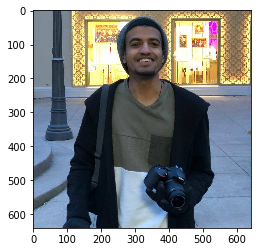

Hi human, You look like a: Basenji , a dog breed LOL



In [35]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.


##The output is better than i thought it would be for a 66% accuracy VGG19 Model
##It might be even better when i augment the data, I also think that the model has to be trained with even bigger dataset 
##with more features, it would also be nice if i added more layers to it.

human_dog_detector('my_images/photo.jpg')


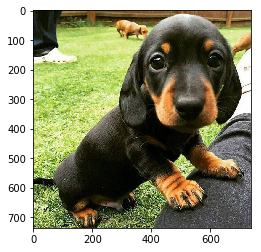

OMG Its a cute dog!, and the breed is Dachshund



In [36]:
human_dog_detector('my_images/dog1.jpg')

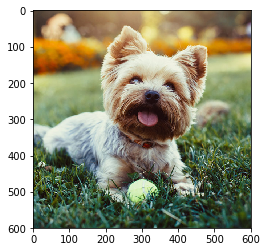

OMG Its a cute dog!, and the breed is Cairn_terrier



In [37]:
human_dog_detector('my_images/dog2.jpg')

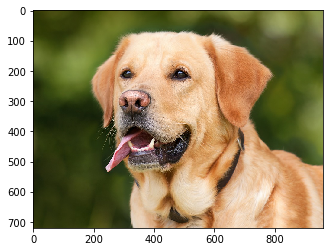

OMG Its a cute dog!, and the breed is Labrador_retriever



In [38]:
human_dog_detector('my_images/dog3.jpg')

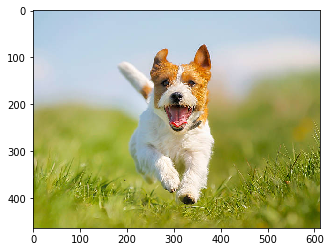

OMG Its a cute dog!, and the breed is Ibizan_hound



In [39]:
human_dog_detector('my_images/dog4.jpg')

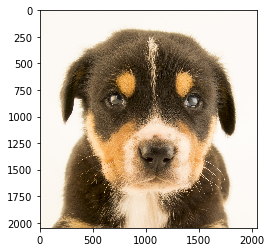

OMG Its a cute dog!, and the breed is Greater_swiss_mountain_dog



In [40]:
human_dog_detector('my_images/dog5.jpg')

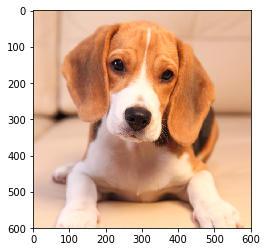

OMG Its a cute dog!, and the breed is Beagle



In [41]:
human_dog_detector('my_images/dog6.jpg')

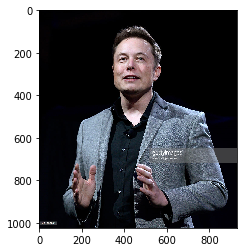

Hi human, You look like a: Xoloitzcuintli , a dog breed LOL



In [42]:
human_dog_detector('my_images/elon.jpg')